In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

In [2]:
# set working directory - note: all code runs from the src folder
wrk_dir = os.getcwd()
# data path
data_path = wrk_dir + '\\' + 'data' + '\\'
# results path
resu_path = wrk_dir + '\\' + 'results\\counterfactuals' + '\\'

In [3]:
df    = pd.read_csv(data_path + 'Karimi2020_v2.csv', sep='|', )
print(df.shape)
cf_df = pd.read_csv(resu_path + 'cf_Karimi2020_v2.csv', sep='|', )
print(cf_df.shape)

(4993, 6)
(4993, 6)


(array([1947.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3046.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

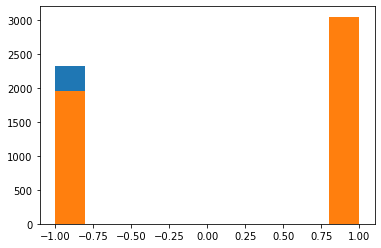

In [4]:
plt.hist(df['LoanApproval'])
plt.hist(cf_df['LoanApproval']) # number of denied loans drops!

In [5]:
feat_trgt = ['LoanApproval']
feat_rlvt = ['AnnualSalary', 'AccountBalance']
feat_prot = ['Gender']


# future params!
protected_group_info = {'Gender': 1}
n_neighbors = 10 # determine by power analysis? (future extension)


Under counterfactual situation testing, for the protected group we need to create two groups: a *control group* (CG) centered on the factuals and a *test group* (TG) centered on the counterfactuals. In practice, this means that we take individual women and compare them to other similar women using some distance $d_1$ to construct CG, while we take their corresponding counterfactuals and compare them to similar men using some distance $d_2$. We start off with $d_1=d_2$. We create the groups using a KNN algorithm.

Under this approach, rather than centering both CG and TG on the same (factual) instance, we construct the hypothetical group (*what would have happened had the female individual been male?*) by allowing for all variables to adjust due to the change in $A$. This is our implementation of what Kohler defined as *fairness given the difference* and what she arguess through her Eddie Murphy paper.

In [6]:
df[df['Gender']==1].shape[0]/df.shape[0]*100 # perc. of women in df
#df[df['Gender']==0].shape[0]/df.shape[0]*100

34.28800320448628

In [12]:
# 1) Setup the respectice search spaces

search_ctr_group = df[df['Gender']==1].copy()
print(search_ctr_group.shape)

search_tst_group = cf_df[cf_df['Gender']==0].copy()
print(search_tst_group.shape)

(1712, 6)
(3281, 6)


In [13]:
# keep track of old / new indices: KNN seems to retunr indices that are absolute (?)
search_ctr_group.reset_index(inplace=True)
search_tst_group.reset_index(inplace=True)

In [14]:
search_ctr_group.head(5)

,index,LoanApproval,AnnualSalary,AccountBalance,u1,u2,Gender
0,0,-1.0,35000,7947.678090,50000,-973.152642,1
1,4,1.0,201000,59008.567839,210000,-705.778380,1
2,5,1.0,102000,26000.811689,120000,-3172.991276,1
3,6,-1.0,68000,15064.447848,80000,-4250.951913,1
4,9,-1.0,84500,21275.931413,110000,-2370.655115,1


In [15]:
search_tst_group.head(5)

,index,u_AnnualSalary,u_AccountBalance,AnnualSalary,AccountBalance,LoanApproval,Gender
0,1,19344.71,950.86,120000.0,36940.10,1.0,0
1,2,-10655.29,-3458.07,90000.0,23564.13,-1.0,0
2,3,-20655.29,3563.38,80000.0,27596.57,-1.0,0
3,7,39344.71,3749.71,140000.0,45716.98,1.0,0
4,8,-30655.29,1496.47,70000.0,22540.65,-1.0,0


In [ ]:
# 2) For eahc ind(ividual) set the centers

ind = 0

center_ctr = df.loc[ind, feat_rlvt]
print(center_ctr)
center_tst = cf_df.loc[ind, feat_rlvt]
print(center_tst)

# prepare for knn
center_ctr = center_ctr.values.reshape(1, -1)
center_tst = center_tst.values.reshape(1, -1)

In [21]:
# let's test the knn... use one feature
# search_ctr_group = df[df['Gender']==1][['AnnualSalary']].copy()
# print(search_ctr_group.shape)
# search_tst_group = cf_df[cf_df['Gender']==0][['AnnualSalary']].copy()
# print(search_tst_group.shape)

search_ctr_group = search_ctr_group[['AnnualSalary']]
print(search_ctr_group.shape)
search_tst_group = search_tst_group[['AnnualSalary']]
print(search_tst_group.shape)

ind = 0
center_ctr = df.loc[ind, 'AnnualSalary']
print(center_ctr)
center_tst = cf_df.loc[ind, 'AnnualSalary']
print(center_tst)

center_ctr = center_ctr.reshape(-1, 1)
center_tst = center_tst.reshape(-1, 1)

(1712, 1)
(3281, 1)
35000
50796.35


In [43]:
# knn = NearestNeighbors(n_neighbors = 10, 
#                        algorithm='ball_tree', 
#                        metric = 'euclidean').fit(search_ctr_group.drop([ind]))
knn = NearestNeighbors(n_neighbors = 10, 
                       algorithm='ball_tree', 
                       metric = 'euclidean').fit(search_ctr_group)
knn

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=10)

In [44]:
distances, indices = knn.kneighbors(center_ctr)

In [45]:
distances

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 500.]])

In [46]:
indices

array([[ 857,  811, 1648, 1247,   22,  359,    0,  786,  131,  887]],
      dtype=int64)

In [48]:
df.loc[0,]

LoanApproval         -1.000000
AnnualSalary      35000.000000
AccountBalance     7947.678090
u1                50000.000000
u2                 -973.152642
Gender                1.000000
Name: 0, dtype: float64

In [49]:
search_ctr_group.loc[857,]

AnnualSalary    35000
Name: 857, dtype: int64

In [50]:
search_ctr_group.loc[811,]

AnnualSalary    35000
Name: 811, dtype: int64

In [35]:
60500 - 35000

25500

In [27]:
df.loc[785,]

LoanApproval         -1.000000
AnnualSalary      80000.000000
AccountBalance    25652.631099
u1                80000.000000
u2                 1652.631099
Gender                0.000000
Name: 785, dtype: float64

In [ ]:
search_ctr_group.loc[785,]

In [40]:
from sklearn.neighbors import BallTree
rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))
print(X)
print('---')
print(X[:1])
tree = BallTree(X, leaf_size=2)              
dist, ind = tree.query(X[:1], k=3)                
print(ind)  # indices of 3 closest neighbors
#[0 3 1]
print(dist)  # distances to 3 closest neighbors
#[ 0.          0.19662693  0.29473397]

[[0.5488135  0.71518937 0.60276338]
 [0.54488318 0.4236548  0.64589411]
 [0.43758721 0.891773   0.96366276]
 [0.38344152 0.79172504 0.52889492]
 [0.56804456 0.92559664 0.07103606]
 [0.0871293  0.0202184  0.83261985]
 [0.77815675 0.87001215 0.97861834]
 [0.79915856 0.46147936 0.78052918]
 [0.11827443 0.63992102 0.14335329]
 [0.94466892 0.52184832 0.41466194]]
---
[[0.5488135  0.71518937 0.60276338]]
[[0 3 1]]
[[0.         0.19662693 0.29473397]]
